In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
# pip install https://github.com/JamesRitchie/scikit-rvm/archive/master.zip
from skrvm import RVR
from sklearn.svm import SVR
from julearn import run_cross_validation
from julearn.utils import configure_logging
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn import plotting
from nilearn import image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.inspection import permutation_importance
sys.path.append("../lib")
from create_splits import stratified_splits

#configure_logging(level='INFO')
# TODO: do with FDG template
# in case seaborn conflicts with autocomplete
df = pd.read_csv('../data/test_train_MRI.csv', index_col=0)

df_train = df[df['train'] == "T"]
col = [x for x in df_train.columns if 'H_' in x]

X = df_train[col].values
y_pseudo = df_train['Age_bins']
y = df_train['Age'].values
# round to no decimal place
y = np.around(y).astype(int)

rand_seed = 42
num_bins = 5
rvr = RVR()
models = [rvr, 'svm']
model_names = ['rvr', 'svm']
# creates dictionary of test indices for different repeats

cv_folds = stratified_splits(bins_on=y_pseudo, num_bins=num_bins,
                             data=df_train, num_splits=5,
                             shuffle=True, random_state=42)
score_results = []
model_results = []
for i, model in enumerate(models):
    cv = StratifiedKFold(n_splits=5).split(X, y_pseudo)
    scores, model =run_cross_validation(X=X, y=y,
                                  #preprocess_X='scaler_robust',
                                  problem_type='regression',
                                  model=model, cv=cv,
                                  return_estimator='final',
                                  seed=rand_seed, scoring=['r2', 'neg_mean_absolute_error'])
    score_results.append(scores)
    model_results.append(model)


c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [4]:
print("RESULTS")
print("\nRIDGE VECTOR REGRESSION:\nR2: ", np.round(np.mean(score_results[0]['test_r2']),2),
      "\nMAE: ", np.abs(np.round(np.mean(score_results[0]['test_neg_mean_absolute_error']),2)))
print("\nSUPPORT VECTOR MACHINE:\nR2: ", np.round(np.mean(score_results[1]['test_r2']),2),
      "\nMAE: ", np.abs(np.round(np.mean(score_results[1]['test_neg_mean_absolute_error']),2)))


RESULTS

RIDGE VECTOR REGRESSION:
R2:  -0.02 
MAE:  5.16

SUPPORT VECTOR MACHINE:
R2:  -0.02 
MAE:  5.06


### Plot Relevant Regions

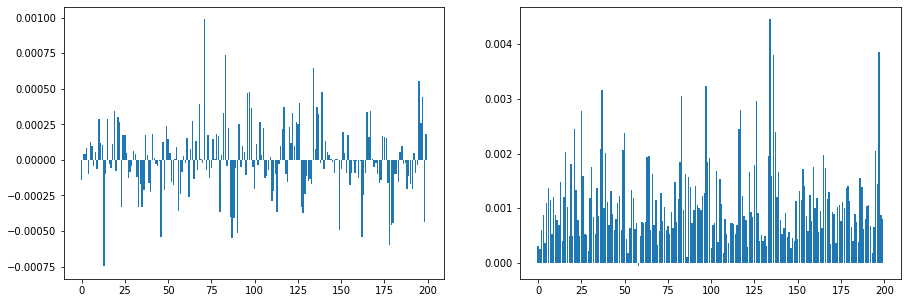

In [5]:
# permutation importance
rvr.fit(X,y)
rvr_feature_importance = permutation_importance(model_results[0]['rvr'],X,y, scoring="r2")
svm = SVR().fit(X,y)
svr_feature_importance = permutation_importance(svm,X,y, scoring="r2")
fig,ax = plt.subplots(1,2, figsize = (15,5))
ax[0].bar(range(X.shape[1]),rvr_feature_importance.importances_mean)
ax[1].bar(range(X.shape[1]),svr_feature_importance.importances_mean)
plt.show()

In [6]:
# threshold importance indication for better interpretability
rvr_imp = [x if x>=0.001 or x<-0.001 else 0 for x in rvr_feature_importance.importances_mean]
svr_imp = [x if x>=0.002 else 0 for x in svr_feature_importance.importances_mean]

# labels
rvr_labels = [col[x] if rvr_imp[x]!=0 else "" for x in range(200)]
svr_labels = [col[x] if svr_imp[x]!=0 else "" for x in range(200)]

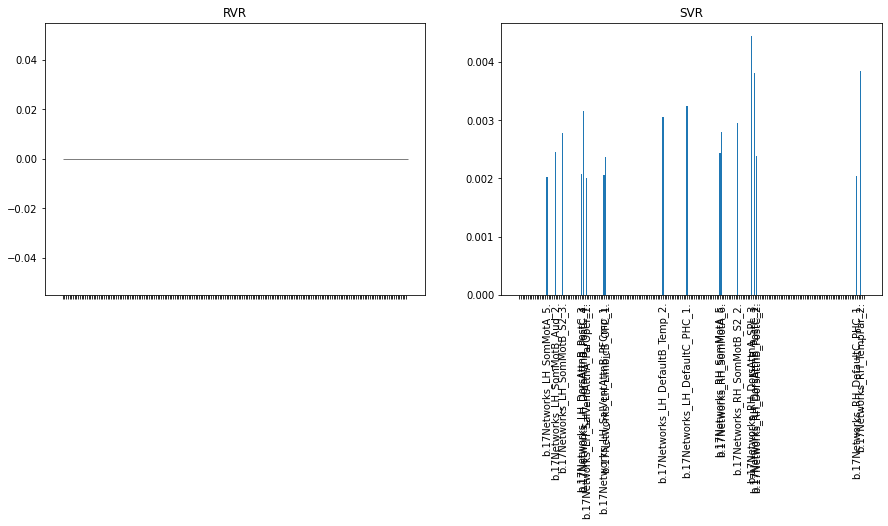

In [7]:
fig,ax = plt.subplots(1,2, figsize = (15,5))
ax[0].bar(range(X.shape[1]),rvr_imp)
ax[0].set_title("RVR")
ax[0].hlines(0,0,200,color='black', linewidth = 0.5)
plt.sca(ax[0])
plt.xticks(range(200),rvr_labels, rotation = 90)
ax[1].bar(range(X.shape[1]),svr_imp)
ax[1].set_title("SVR")
plt.sca(ax[1])
plt.xticks(range(200),svr_labels, rotation = 90)
plt.show()

### Plot Relevant Regions in Glass Brain

In [8]:
schaefer = fetch_atlas_schaefer_2018(n_rois = 200, yeo_networks = 17)
atlas = image.load_img(schaefer.maps)
atlas_matrix = image.get_data(atlas)

In [9]:
# create statistical map where each voxel value coresponds to permutation importance
rvr_imp = rvr_feature_importance.importances_mean
atlas_matrix_stat = atlas_matrix.copy()

for x in range(201):
    if x == 0: 
        pass
    else:
        atlas_matrix_stat[atlas_matrix_stat==x] = rvr_imp[x-1]
atlas_rvr = image.new_img_like(atlas, atlas_matrix_stat)


In [10]:
svr_imp = svr_feature_importance.importances_mean
atlas_matrix_stat_svr = atlas_matrix.copy()

for x in range(201):
    if x == 0: 
        pass
    else:
        atlas_matrix_stat_svr[atlas_matrix_stat_svr==x] = svr_imp[x-1]
atlas_svr = image.new_img_like(atlas, atlas_matrix_stat_svr)

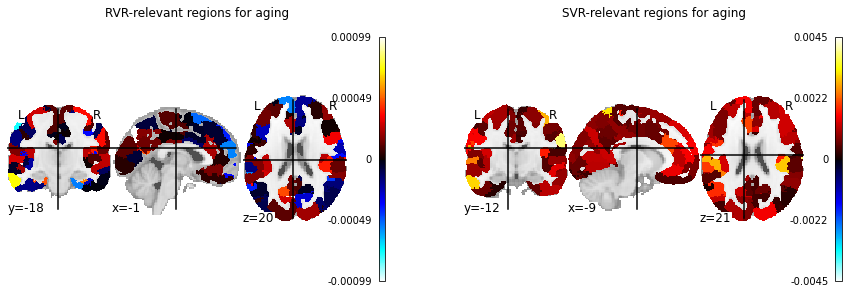

In [11]:
fix, ax = plt.subplots(1,2, figsize=(15,5))
plotting.plot_stat_map(atlas_rvr, axes = ax[0])
ax[0].set_title("RVR-relevant regions for aging")
plotting.plot_stat_map(atlas_svr, axes = ax[1])
ax[1].set_title("SVR-relevant regions for aging")
plt.show()

### Performance on test set

In [25]:
df_test = df[df['train'] == "F"]
col = [x for x in df_train.columns if 'H_' in x]

X_test = df_test[col].values
#y_pseudo = df_test['Age_bins']
y_test = df_test['Age'].values
# round to no decimal place
y_test = np.around(y_test).astype(int)

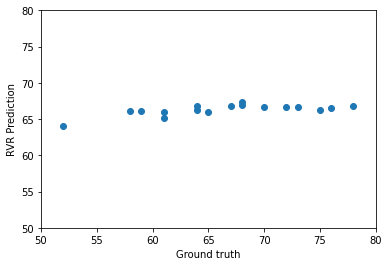

In [26]:
pred = model_results[0]['rvr'].predict(X_test)
plt.scatter(y_test, pred)
plt.xlabel("Ground truth")
plt.ylabel("RVR Prediction")
plt.xlim(50,80)
plt.ylim(50,80)
plt.show()